# Pylops - seismic interpolation

### Author: M.Ravasi

In this notebook I will implement and compare different ways to perform interpolation of seismic data onto a regular grid from data acquired by an irregularly sampled array of receivers.

The problem of seismic data interpolation is a very simple one, yet very ill-posed and hard to solve. Our forward modelling operator is a simple *restriction* or *sampling* operator which is applied along the spatial direction(s). 

$$\mathbf{y} = \mathbf{R} \mathbf{x}$$

where $\mathbf{y} = [\mathbf{y}_{R1}^T, \mathbf{y}_{R2}^T,..., \mathbf{y}_{RN^T}]^T$ and each vector  $\mathbf{y}_{Ri}$ contains all time samples recorded in the seismic data at the specific receiver $R_i$. Similarly, $\mathbf{x} = [\mathbf{x}_{r1}^T, \mathbf{x}_{r2}^T,..., \mathbf{x}_{rM}^T]$, contains all traces at the regularly and finely sampled idea array of receivers $r_i$.

The forward model simply selects a subset of sources/receivers from the input vector which is assumed to have a fine and regularly sampled array of receivers (which is what we wish to recover via inversion), while its adjoint places those values at the correct locations in the input vector. 

In [14]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from scipy.signal import convolve

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.seismicinterpolation           import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import FISTA

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 2D

# Linear events

In [9]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':140,
       'oy':0,'dy':2,    'ny':101,
       'ot':0,'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
theta_m = [0, 30, -60]
phi_m   = [0]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear2d(xaxis, taxis, v, t0_m, theta_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=-150.634990 - u^T(Op^Tv)=-150.634990


### Inversion in time-space domain with spatial smoothing

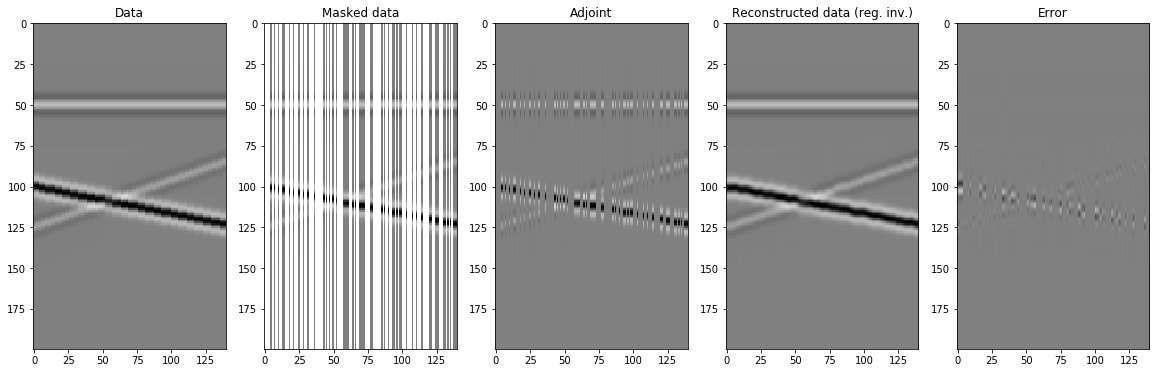

In [11]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['nx']*par['nt'], dims=(par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape( par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

(140, 200)
Dot test passed, v^T(Opu)=-4.437192 - u^T(Op^Tv)=-4.437192
<11200x28000 Restriction with dtype=float64>
<28000x28000 SecondDerivative with dtype=float64>
(56, 200)


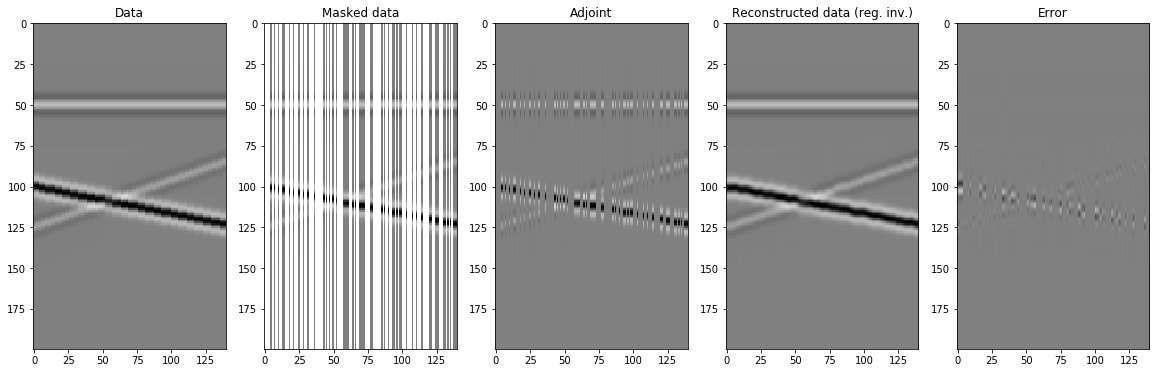

In [30]:
xinvf, _ = SeismicInterpolation(y, par['nx'], iava, kind='spatial', dottest=True,
                                  **dict(epsRs=[np.sqrt(0.1)], returninfo=False,
                                         damp=np.sqrt(1e-4), iter_lim=200 ,show=0))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

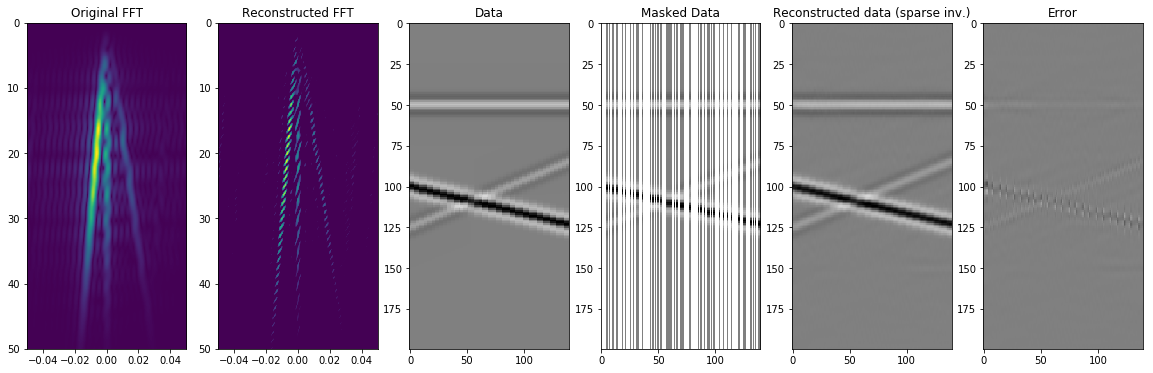

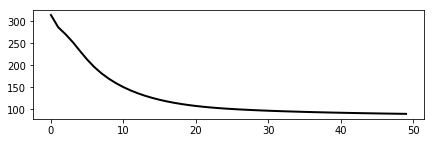

In [45]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=50, eps=1e-2, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfft, nfft)
xl1 = np.real(xl1.reshape( par['nx'], par['nt']))

fig, axs = plt.subplots(1, 6, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked Data')
axs[3].axis('tight');
axs[4].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

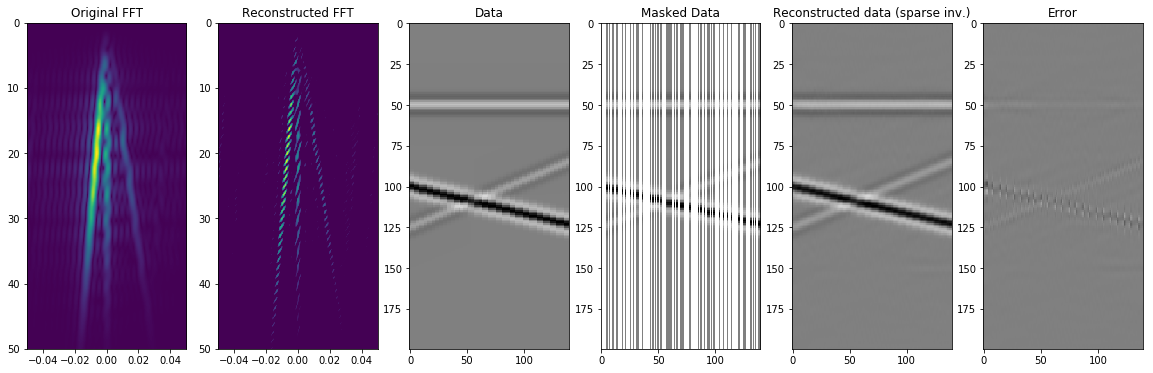

In [68]:
xinvf, pinvf = SeismicInterpolation(y, par['nx'], iava, kind='fk', nffts=(nfft, nfft), 
                                    sampling=(par['dx'], par['dt']), dottest=False,
                                    **dict(niter=50, eps=1e-2, returninfo=True))

fig, axs = plt.subplots(1, 6, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pinvf[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked Data')
axs[3].axis('tight');
axs[4].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

### Inversion in linear Radon domain with sparsity-promoting solver

First we just setup and apply Radon to the full data

Dot test passed, v^T(Opu)=-3544.724040 - u^T(Op^Tv)=-3544.724040


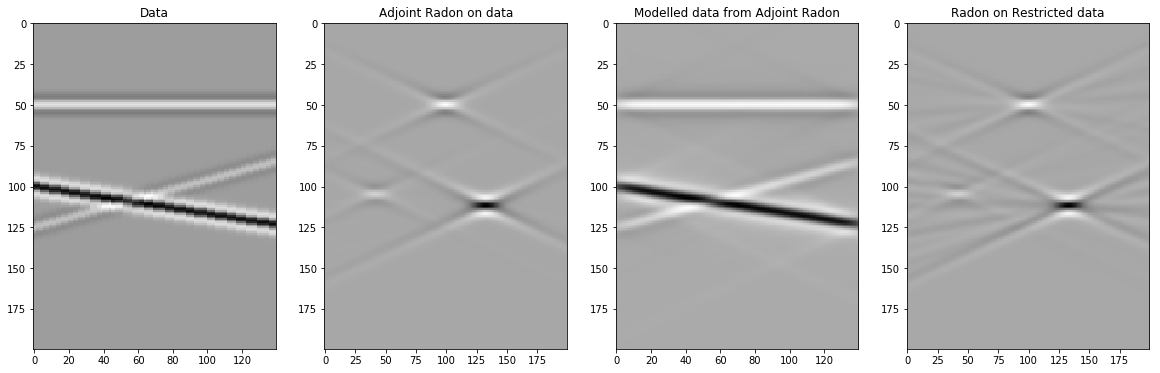

In [47]:
npx=200
pxmax = 1e-3
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

Then we apply sparse inversion

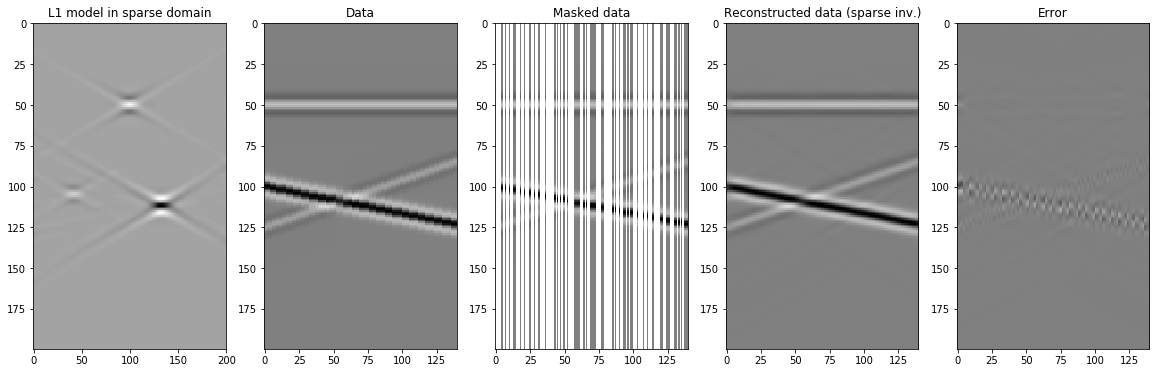

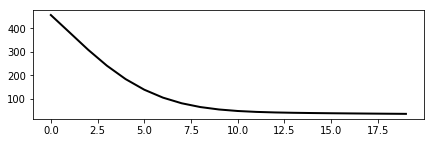

In [48]:
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=20, eps=5e-1, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pl1.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

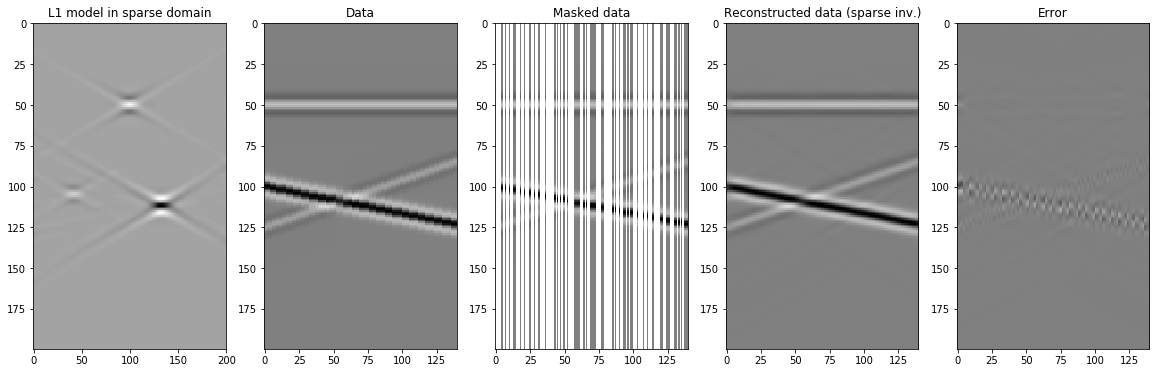

In [66]:
xinvf, pinvf = SeismicInterpolation(y, par['nx'], iava, kind='radon-linear', spataxis=xaxis, 
                                    taxis=taxis, paxis=px, centeredh=True, dottest=False,
                                    **dict(niter=20, eps=5e-1, returninfo=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinvf.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

# Parabolic events

In [69]:
###### Input parameters
par = {'ox':0, 'dx':2,    'nx':140,
       'oy':0, 'dy':2,    'ny':100,
       'ot':0, 'dt':0.004,'nt':200,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.2, 0.4, 0.5]
px_m = [0, 0, 0]
pxx_m = [1e-5, 5e-6, 1e-6]
amp_m   = [1., -2, 0.5]

# Create axis
t,t2,x,y = makeaxis(par)

# Create wavelet
wav = ricker(t[:41], f0=par['f0'])[0]

# Generate model
_, x =  parabolic2d(x,t, t0_m, px_m, pxx_m,amp_m,wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=-33.626834 - u^T(Op^Tv)=-33.626834


### Inversion in time-space domain with spatial smoothing

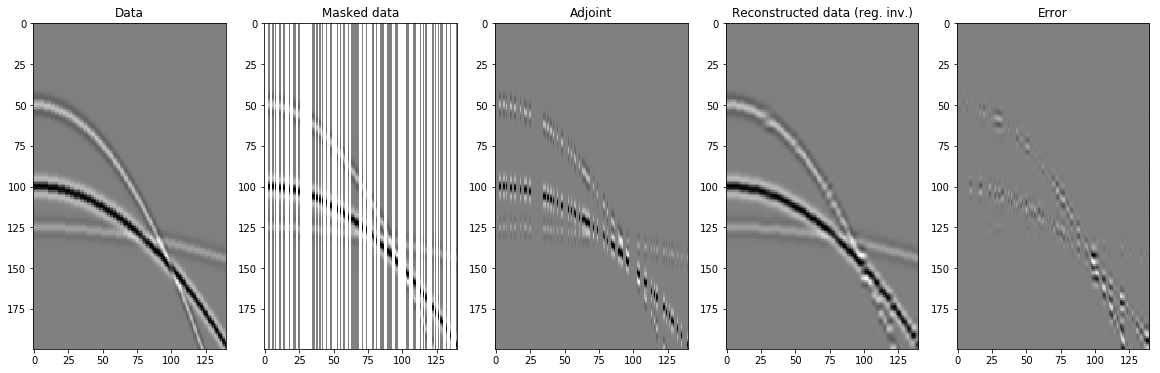

In [8]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['nx']*par['nt'], dims=(par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape( par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

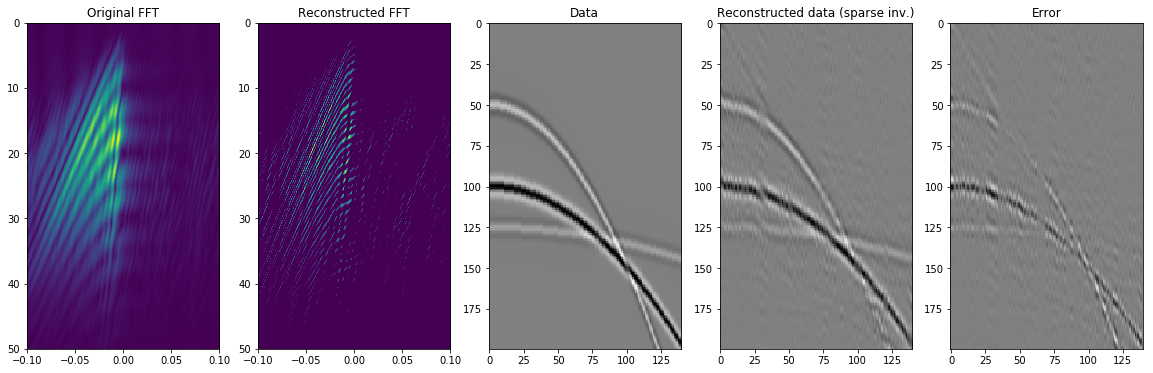

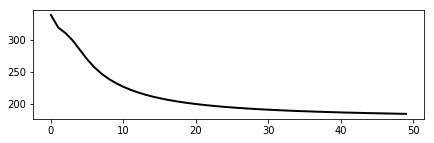

In [9]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
X = FFTop*x.flatten()
X = np.reshape(X, (nfft, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=50, eps=1e-2, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfft, nfft)
xl1 = np.real(xl1.reshape( par['nx'], par['nt']))

fig, axs = plt.subplots(1, 6, figsize=(20, 6))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked Data')
axs[3].axis('tight');
axs[4].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in parabolic Radon domain with sparsity-promoting solver

First we just setup and apply Radon to the full data

Dot test passed, v^T(Opu)=1561.514422 - u^T(Op^Tv)=1561.514422


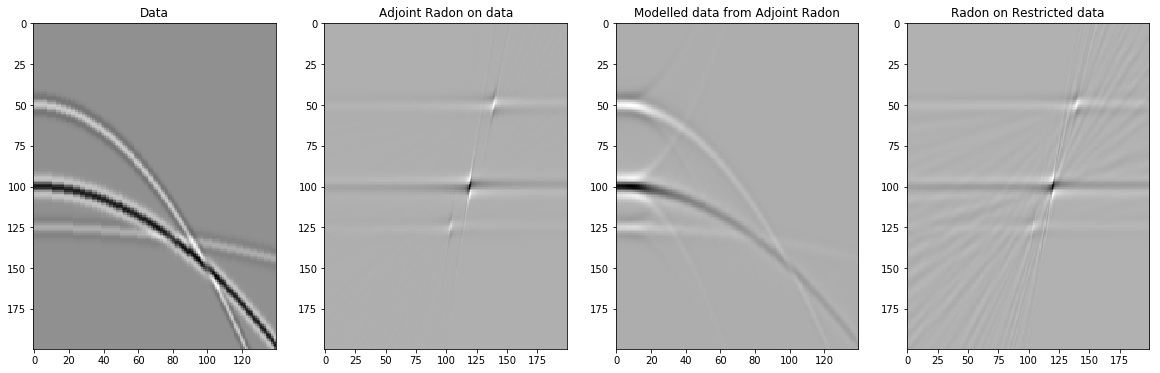

In [70]:
npx=200
pxmax = 5e-5
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=False, kind='parabolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x.T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

Then we apply sparse inversion

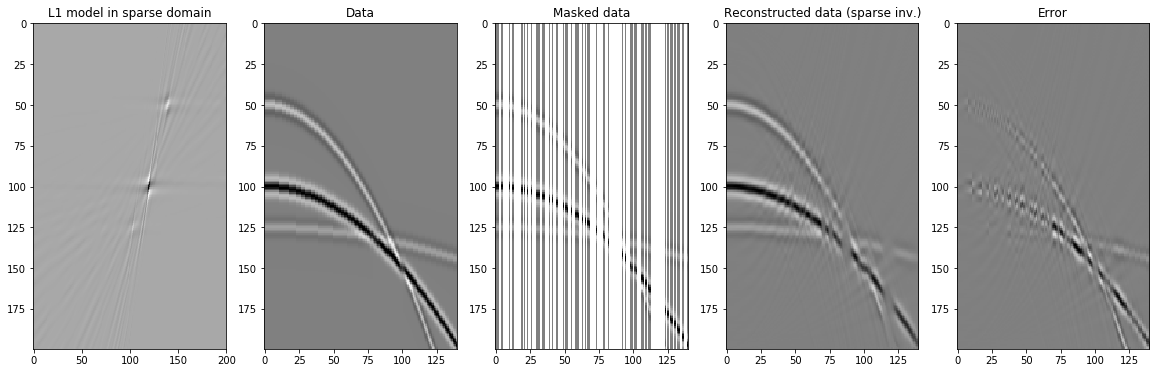

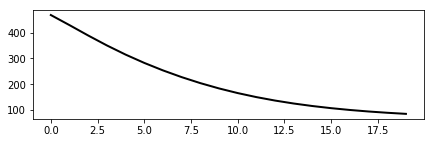

In [71]:
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=20, eps=5e-1, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pl1.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

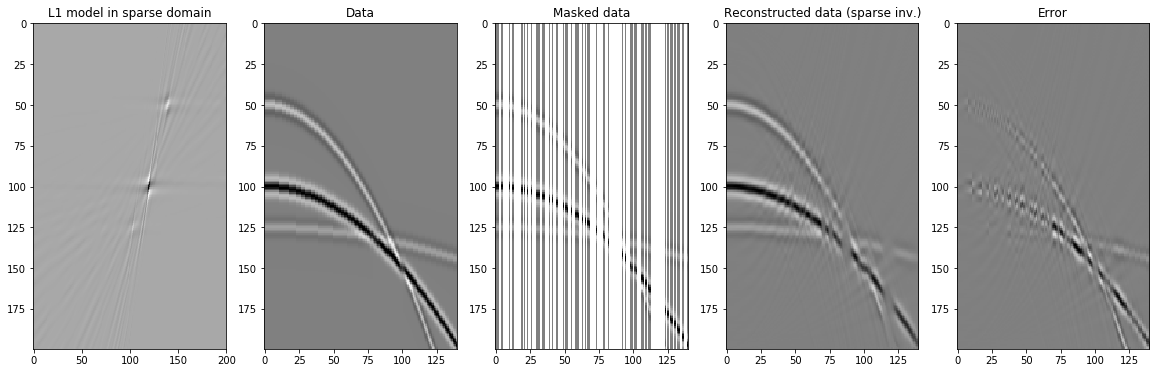

In [73]:
xinvf, pinvf = SeismicInterpolation(y, par['nx'], iava, kind='radon-parabolic', spataxis=xaxis, 
                                    taxis=taxis, paxis=px, centeredh=False, dottest=False,
                                    **dict(niter=20, eps=5e-1, returninfo=True))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pinvf.T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xinvf.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in sliding linear Radon domain with sparsity-promoting solver

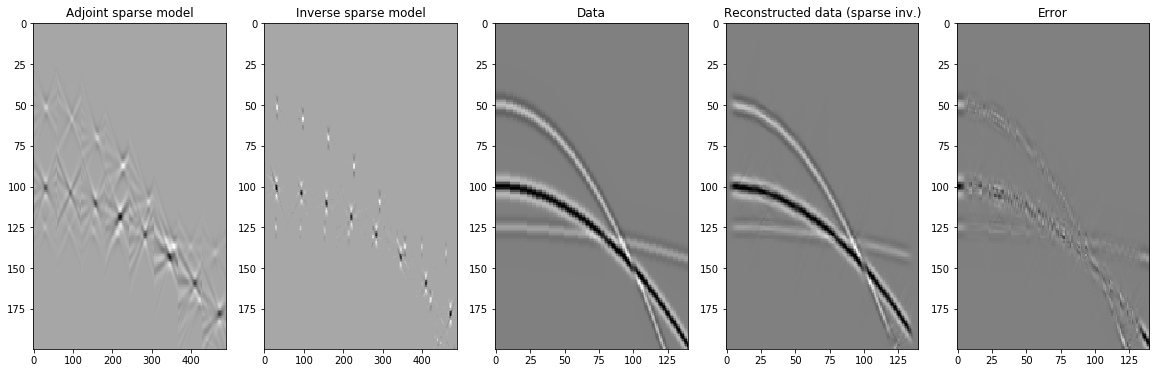

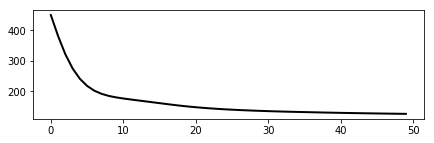

In [12]:
nwin = 26
nwins = 8
nover = 10
npx = 61
px = np.linspace(-5e-3, 5e-3, npx)
dimsd = x.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = Radon2D(t, np.linspace(-par['dx']*nwin//2, par['dx']*nwin//2, nwin), px, centeredh=True,
                            kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine')
dottest(Slidop, np.prod(dimsd), np.prod(dims))

Rop1 = Rop*Slidop

# adjoint
padj = Rop1.H*y.flatten()
padj = padj.reshape(npx*nwins, par['nt'])

# inverse
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=50, eps=5e-1, returninfo=True)
xl1 = Slidop*pl1

pl1 = pl1.reshape(npx*nwins, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(padj.T, cmap='gray')
axs[0].set_title('Adjoint sparse model')
axs[0].axis('tight')
axs[1].imshow(pl1.T, cmap='gray')
axs[1].set_title('Inverse sparse model')
axs[1].axis('tight')
axs[2].imshow(x.T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight')

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

# Realistic data

In [113]:
inputfile = '../../pylops/testdata/marchenko/input.npz'
inputdata = np.load(inputfile)

x = inputdata['R'][50, :, :-100]
x = x/np.abs(x).max()

taxis, xaxis = inputdata['t'][:-100], inputdata['r'][0]
par = {}
par['nx'], par['nt'] = x.shape
par['dx'] = inputdata['r'][0, 1] - inputdata['r'][0, 0]
par['dt'] = inputdata['t'][1] - inputdata['t'][0]

# add wavelet
wav = 0.3*inputdata['wav']
wav_c = np.argmax(wav)
x = np.apply_along_axis(convolve, 1, x, wav, mode='full')
x = x[:, wav_c:][:, :par['nt']]

# gain
gain = np.tile((taxis**2)[:, np.newaxis], (1, par['nx'])).T
x = x*gain

# subsampling locations
perc_subsampling=0.6
Nsub=int(np.round(par['nx']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['nx']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['nx']*par['nt'], iava, dims=(par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nt'],par['nx']*par['nt'], verb=True)

y     = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nt'])
xadj = xadj.reshape( par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=77.589816 - u^T(Op^Tv)=77.589816


### Inversion in time-space domain with spatial smoothing

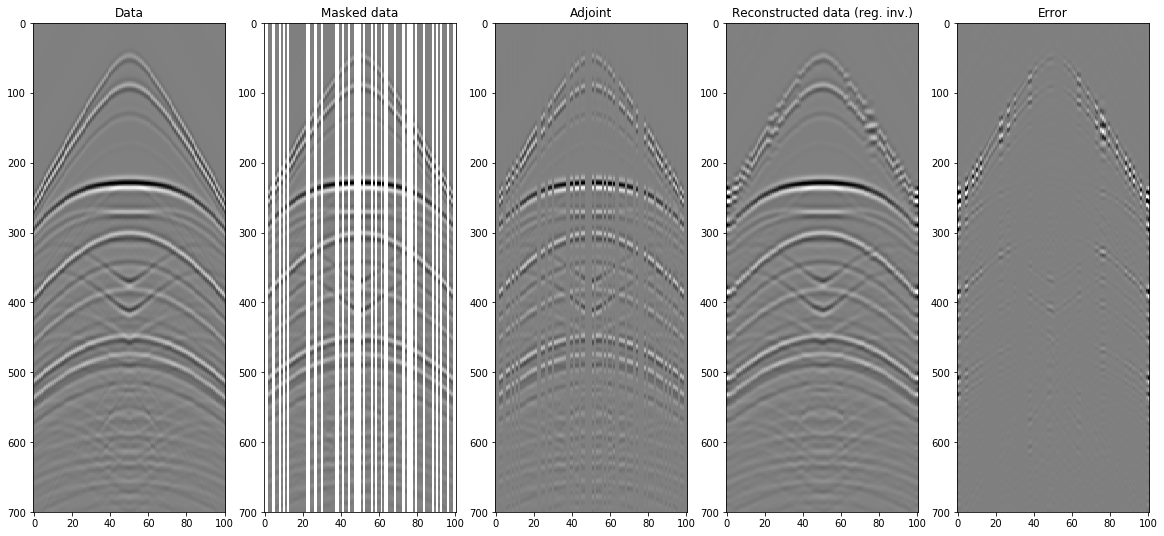

In [5]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['nx']*par['nt'], dims=(par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape( par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x.T-xinv.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

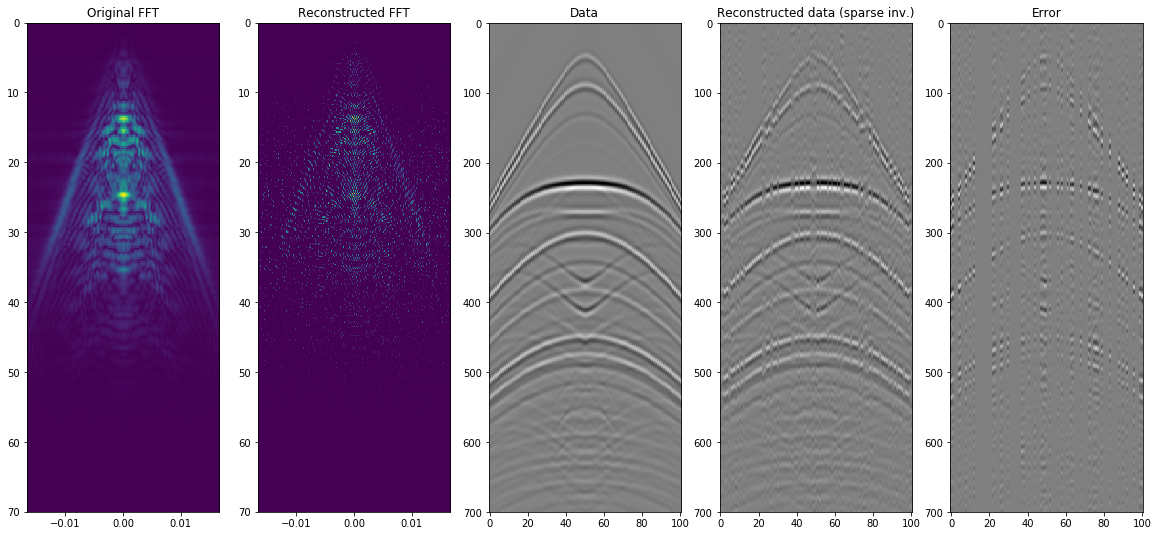

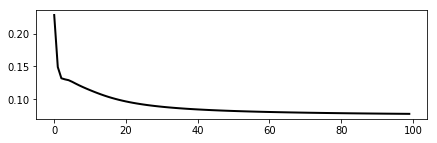

In [6]:
nfft=2**11
FFTop = FFT2D(dims=[par['nx'], par['nt']], nffts=[nfft, nfft], sampling=[par['dx'], par['dt']])
dottest(FFTop, nfft*nfft, par['nx']*par['nt'], complexflag=2)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=100, eps=1e-4, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfft, nfft)
xl1 = np.real(xl1.reshape( par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(70, 0)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, :nfft//2-1]),axes=0).T,
              extent=(np.fft.fftshift(FFTop.f1)[0], np.fft.fftshift(FFTop.f1)[-1], 
                      FFTop.f2[nfft//2-1], FFTop.f2[0]))
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(70, 0)
axs[2].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in parabolic Radon domain with sparsity-promoting solver

Dot test passed, v^T(Opu)=-659.966665 - u^T(Op^Tv)=-659.966665


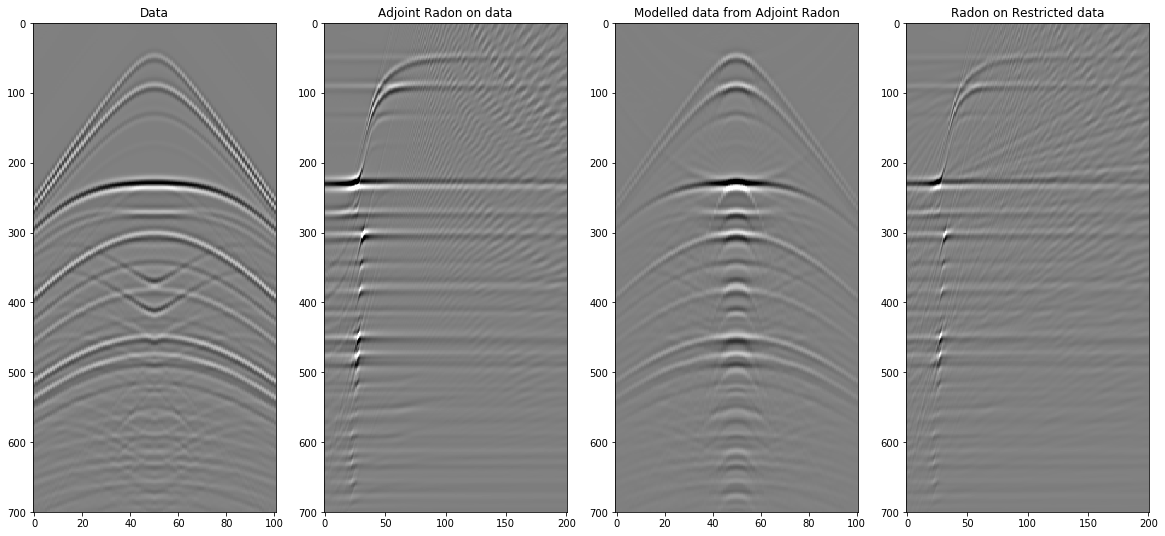

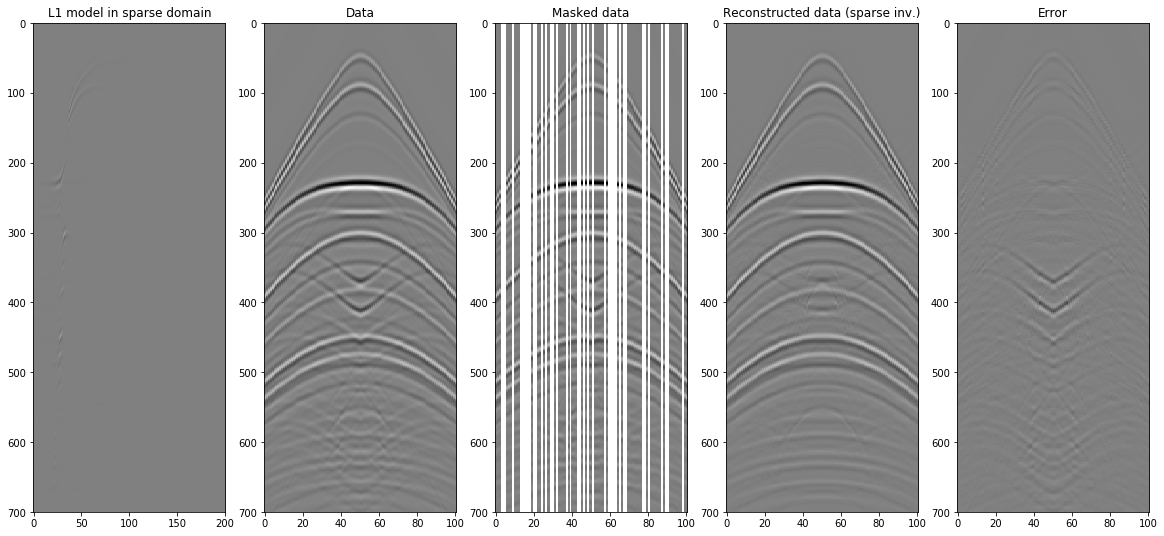

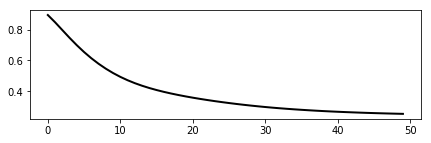

In [118]:
npx=201
pxmax = 4e-5
px = np.linspace(-pxmax/10, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=True, kind='parabolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray', vmin=-50, vmax=50)
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray', vmin=-1, vmax=1)
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

# Sparse inversion
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=50, eps=4e-2, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(pl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in hyperbolic Radon domain with sparsity-promoting solver

Dot test passed, v^T(Opu)=-679.594327 - u^T(Op^Tv)=-679.594327


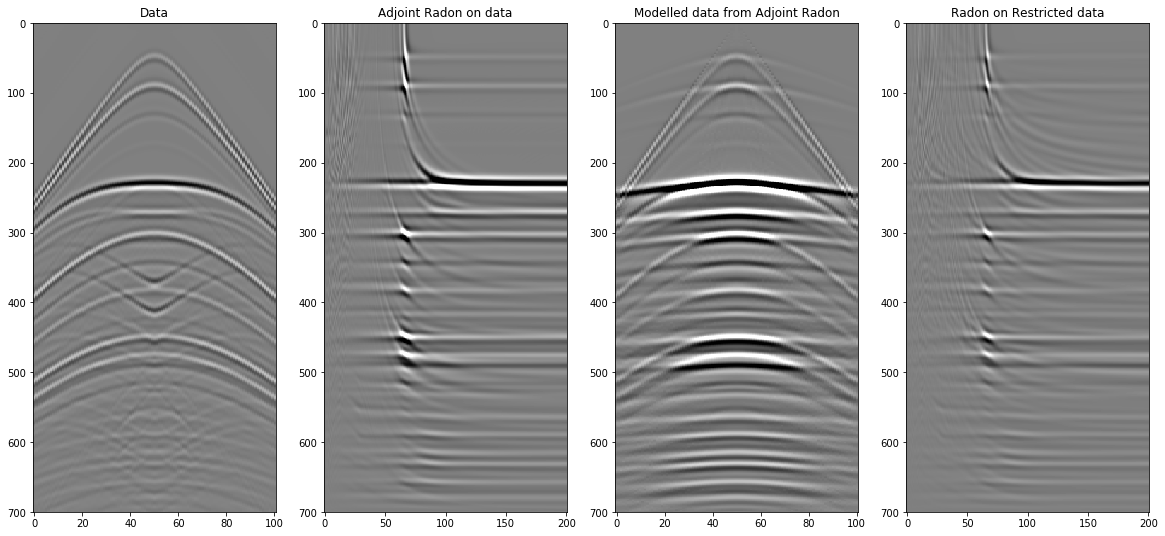

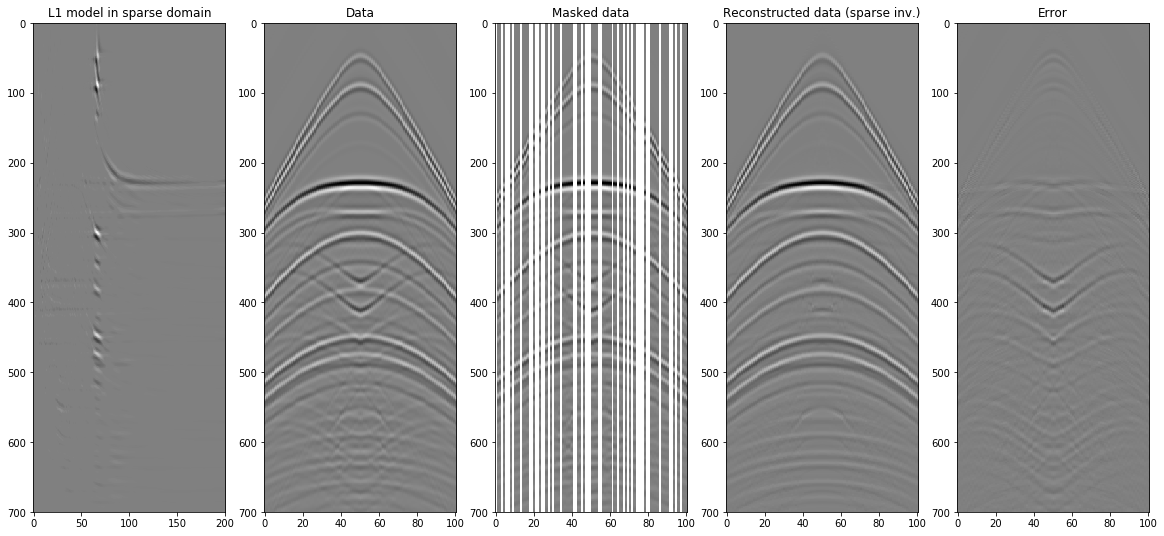

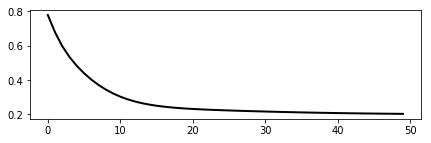

In [17]:
npx=201
pxmax = 5e-5
px = np.linspace(0, pxmax, npx)
Radop = Radon2D(taxis, xaxis, px, centeredh=True, kind='hyperbolic', engine='numba')
dottest(Radop, par['nx']*par['nt'], npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 9))
axs[0].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj.T, cmap='gray', vmin=-1, vmax=1)
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj.T, cmap='gray', vmin=-50, vmax=50)
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj.T, cmap='gray', vmin=-1, vmax=1)
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

# Sparse inversion
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=50, eps=4e-2, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, par['nt'])
xl1 = np.real(xl1.reshape(par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 9))
axs[0].imshow(pl1.T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in sliding linear Radon domain with sparsity-promoting solver

Text(0.5, 1.0, 'Adjoint Radon of Single patch')

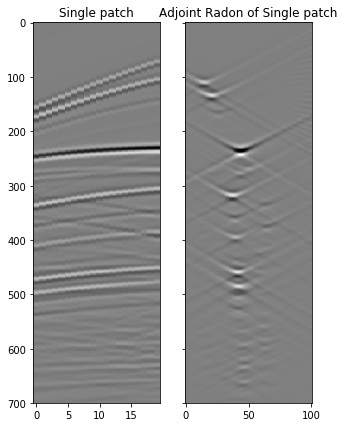

In [18]:
dx = par['dx']
nwin=20
nwins=9
nover=10
npx=101
pxmax = 5e-4
px = np.linspace(-pxmax, pxmax, npx)
dimsd = x.shape
dims = (nwins*npx, dimsd[1])

# sliding window radon with overlap
Op = Radon2D(taxis, np.linspace(-dx*nwin//2, dx*nwin//2, nwin), px, centeredh=True,
             kind='linear', engine='numba')
Slidop = Sliding2D(Op, dims, dimsd, nwin, nover, tapertype='cosine', design=False)
dottest(Slidop, np.prod(dimsd), np.prod(dims))

# radon on one patch
x1 = x[1*nwin:2*nwin]
y1 = Op.H*x1.flatten()
y1 = y1.reshape(npx, par['nt'])

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(5, 7))
axs[0].imshow(x1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[0].axis('tight')
axs[0].set_title('Single patch')

axs[1].imshow(y1.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].axis('tight')
axs[1].set_title('Adjoint Radon of Single patch');

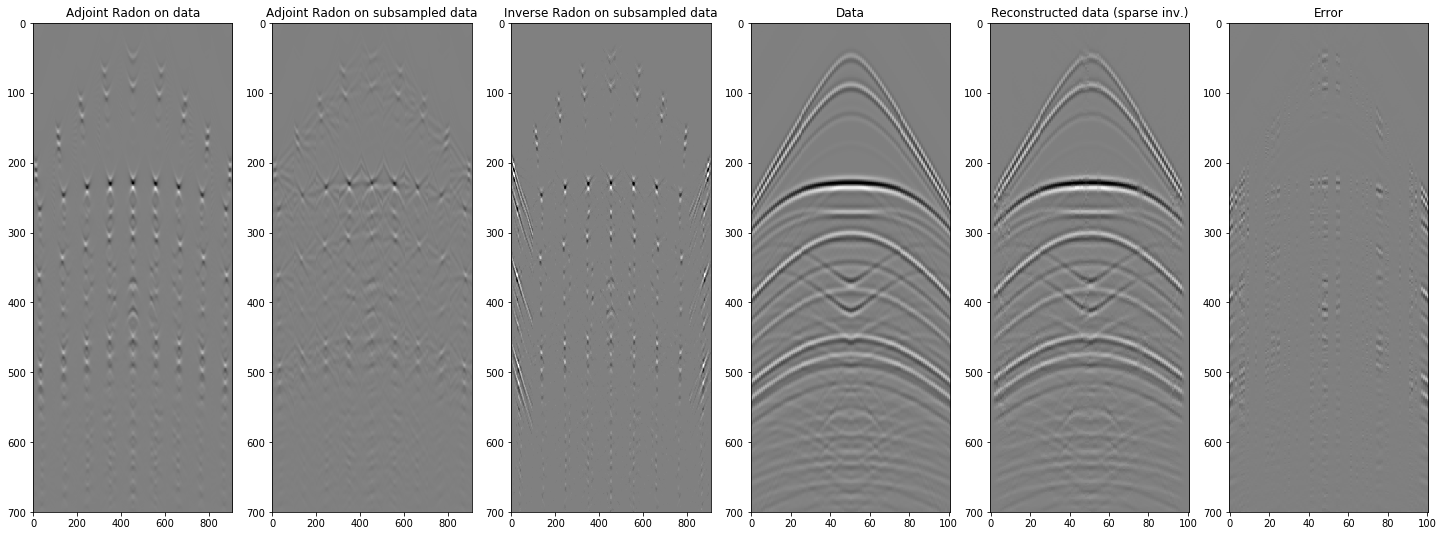

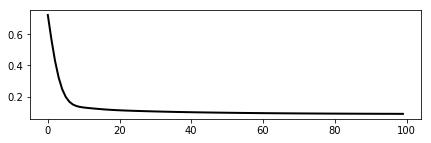

In [19]:
# adjoint
Rop1 = Rop*Slidop

padj_fromx = Slidop.H*x.flatten()
padj_fromx = padj_fromx.reshape(npx*nwins, par['nt'])

padj = Rop1.H*y.flatten()
padj = padj.reshape(npx*nwins, par['nt'])

pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=100, eps=1e-3, returninfo=True)
xl1 = Slidop*pl1

pl1 = pl1.reshape(npx*nwins, par['nt'])
xl1 = xl1.reshape(par['nx'], par['nt'])

fig, axs = plt.subplots(1, 6, figsize=(25, 9))
axs[0].imshow(padj_fromx.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[0].set_title('Adjoint Radon on data')
axs[0].axis('tight')
axs[1].imshow(padj.T, cmap='gray', vmin=-0.5, vmax=0.5)
axs[1].set_title('Adjoint Radon on subsampled data')
axs[1].axis('tight')
axs[2].imshow(pl1.T, cmap='gray', vmin=-0.005, vmax=0.005)
axs[2].set_title('Inverse Radon on subsampled data')
axs[2].axis('tight')
axs[3].imshow(x.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[3].set_title('Data')
axs[3].axis('tight');
axs[4].imshow(xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight')
axs[5].imshow(x.T-xl1.T, cmap='gray', vmin=-0.05, vmax=0.05)
axs[5].set_title('Error')
axs[5].axis('tight')

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

# 3D

# Linear events

In [2]:
###### Input parameters
par = {'ox':0,'dx':2,    'nx':30,
       'oy':0,'dy':2,    'ny':51,
       'ot':0,'dt':0.004,'nt':100,
       'f0': 20, 'nfmax': 210}

v       = 1500
t0_m    = [0.1, 0.2, 0.3]
theta_m = [0, 30, -60]
phi_m   = [0, 50, 30]
amp_m   = [1., -2, 0.5]

# Create axis
taxis, taxis2, xaxis, yaxis = makeaxis(par)

# Create wavelet
wav = ricker(taxis[:41], f0=par['f0'])[0]

# Generate model
m, x =  linear3d(xaxis, yaxis, taxis, v, t0_m, theta_m, phi_m, amp_m, wav)

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(par['ny']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['ny']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['ny']*par['nx']*par['nt'], iava, 
                  dims=(par['ny'], par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=451.674428 - u^T(Op^Tv)=451.674428


### Inversion in time-space domain with spatial smoothing

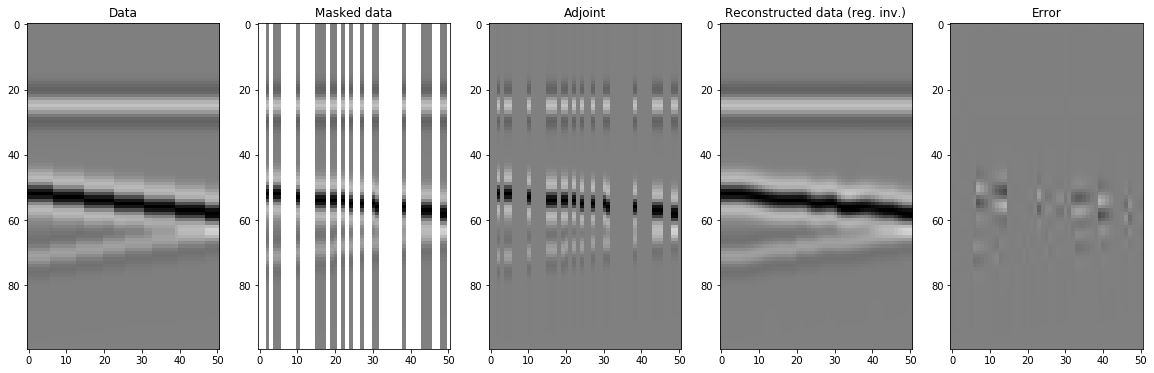

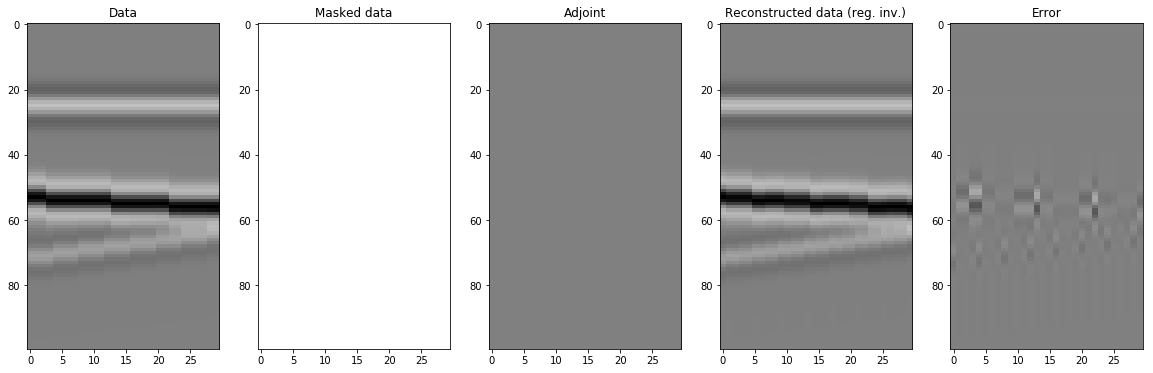

In [25]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['ny']*par['nx']*par['nt'], 
                         dims=(par['ny'], par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[par['ny']//2].T-xinv[par['ny']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

Dot test passed, v^T(Opu)=447.901478 - u^T(Op^Tv)=447.901478


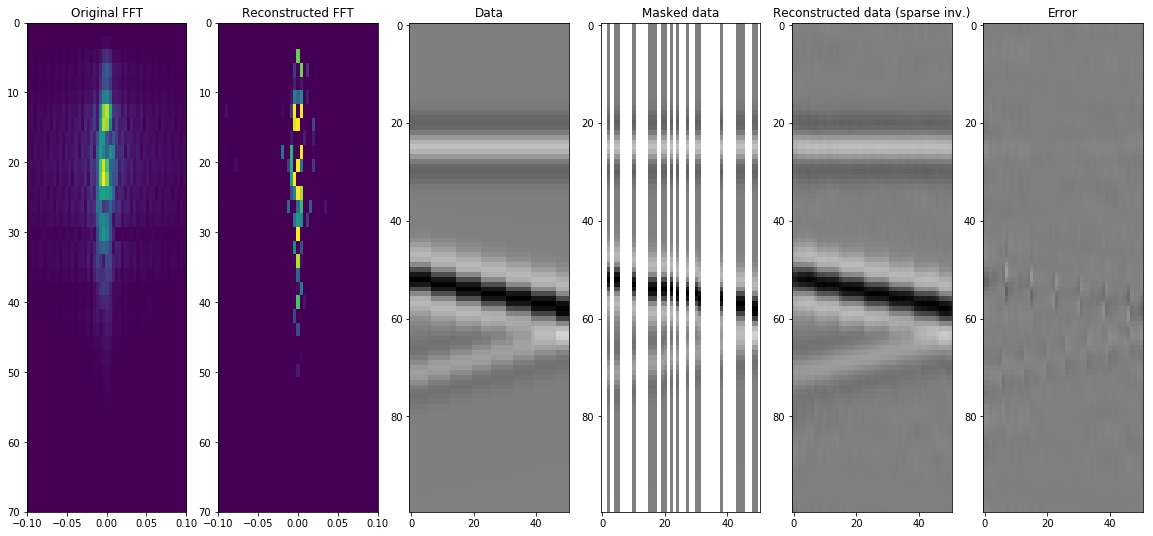

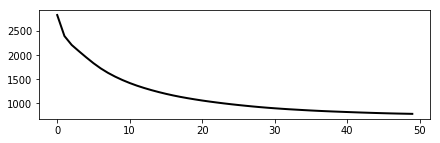

In [28]:
nfft=2**7
FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfft, nfft, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
dottest(FFTop, nfft*nfft*nfft, par['ny']*par['nx']*par['nt'], complexflag=2, verb=True)
p = FFTop*x.flatten()
p = np.reshape(p, (nfft, nfft, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=50, eps=1e-1, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfft, nfft, nfft)
xl1 = np.real(xl1.reshape(par['ny'], par['nx'], par['nt']))

fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, 1, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=10)
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.05, 0.05)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, 1, :nfft//2-1]), axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=10)
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.05, 0.05)
axs[2].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Masked data')
axs[3].axis('tight')
axs[4].imshow(xl1[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x[:, par['nx']//2].T-xl1[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[5].set_title('Error')
axs[5].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in linear Radon domain with sparsity-promoting solver

Dot test passed, v^T(Opu)=-14813.058613 - u^T(Op^Tv)=-14813.058613


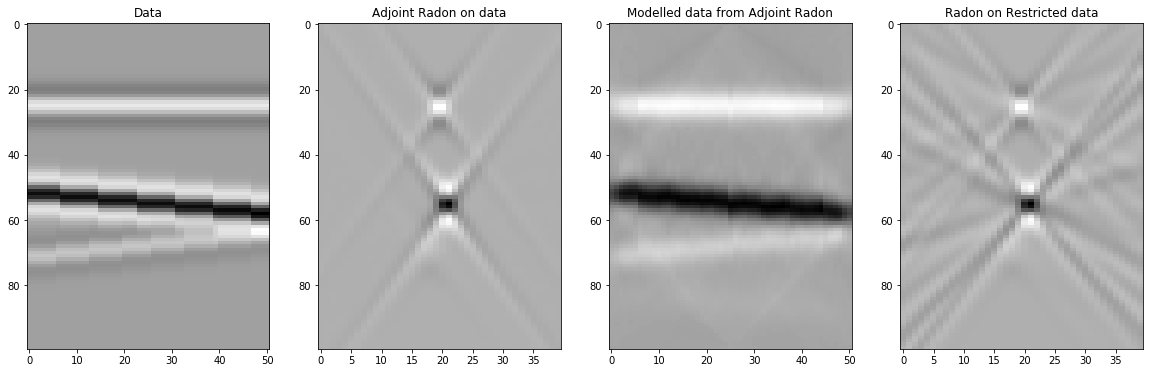

In [26]:
npx=40
pxmax = 4e-3
px = np.linspace(-pxmax, pxmax, npx)
Radop = Radon3D(taxis, yaxis, xaxis, px, px, engine='numba', interp=False)
dottest(Radop, par['ny']*par['nx']*par['nt'], npx*npx*par['nt'], verb=True)

Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['ny'], par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npx, npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj[:, npx//2].T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj[:, par['nx']//2].T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj[:, npx//2].T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

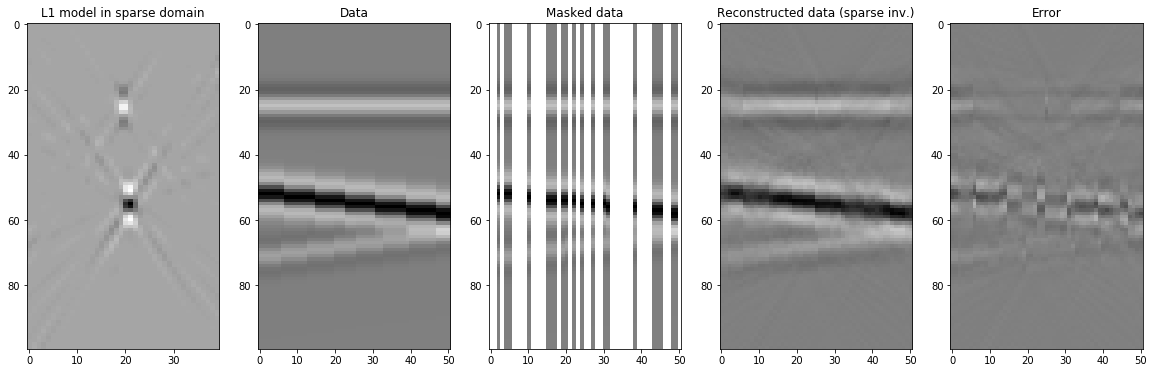

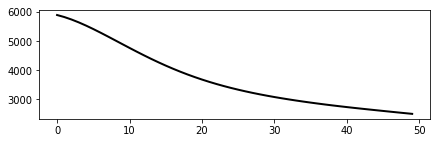

In [27]:
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=50, eps=5e1, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npx, npx, par['nt'])
xl1 = np.real(xl1.reshape(par['ny'], par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pl1[:, npx//2].T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x[:, par['nx']//2].T-xl1[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

# Realistic data

In [119]:
inputfile3d = '../../pylops/testdata/seismicinterpolation/input3D.npz'
inputdata3d = np.load(inputfile3d)

x = np.transpose(inputdata3d['data'], (2, 1, 0))[20:100, :, :300:2]
x = x/np.abs(x).max()

taxis, xaxis, yaxis = inputdata3d['t'][:300:2], inputdata3d['rx'], inputdata3d['ry'][20:100]
par = {}
par['ny'], par['nx'], par['nt'] = x.shape
par['dx'] = inputdata3d['rx'][1] - inputdata3d['rx'][0]
par['dy'] = inputdata3d['ry'][1] - inputdata3d['ry'][0]
par['dt'] = inputdata3d['t'][1] - inputdata3d['t'][0]

# add wavelet
wav = wav[::2]
x = np.apply_along_axis(convolve, 2, x, wav, mode='full')
x = x[:, :, :par['nt']]

# gain
gain = np.transpose(np.tile((taxis**2)[:, np.newaxis, np.newaxis], (1, par['ny'], par['nx'])), (1, 2, 0))
x = x*gain

# subsampling locations
perc_subsampling=0.6
Nsub=int(np.round(par['ny']*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(par['ny']))[:Nsub])

# Create restriction operator
Rop = Restriction(par['ny']*par['nx']*par['nt'], iava, 
                  dims=(par['ny'], par['nx'], par['nt']), dir=0, dtype='float64')
dottest(Rop,Nsub*par['nx']*par['nt'], par['ny']*par['nx']*par['nt'], verb=True)

y = Rop*x.flatten()
xadj = Rop.H*y.flatten()
y = y.reshape(Nsub, par['nx'], par['nt'])
xadj = xadj.reshape( par['ny'], par['nx'], par['nt'])

# Apply mask
ymask = Rop.mask(x.flatten())

Dot test passed, v^T(Opu)=963.105156 - u^T(Op^Tv)=963.105156


### Inversion in time-space domain with spatial smoothing

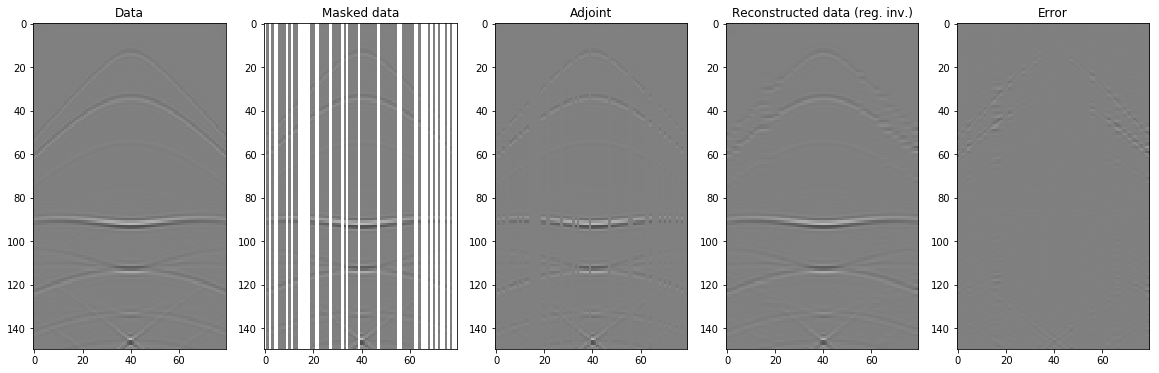

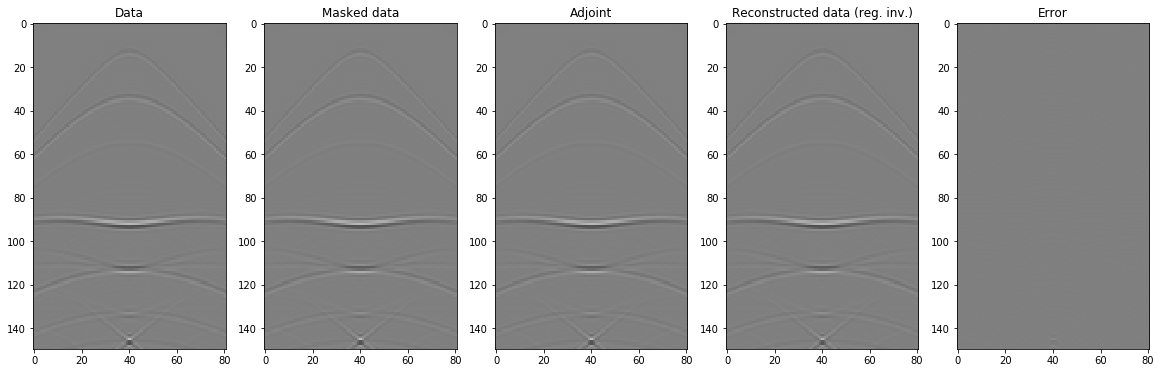

In [96]:
# Invert for interpolated signal
D2op  = SecondDerivative(par['ny']*par['nx']*par['nt'], 
                         dims=(par['ny'], par['nx'], par['nt']), dir=0, dtype='float64')

xinv, istop, itn, r1norm, r2norm = \
    RegularizedInversion(Rop, [D2op], y.flatten(), epsRs=[np.sqrt(0.1)], returninfo=True,
                         **dict(damp=np.sqrt(1e-4), iter_lim=200 ,show=0))
xinv = xinv.reshape(par['ny'], par['nx'], par['nt'])

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[:, par['nx']//2].T-xinv[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[4].set_title('Error')
axs[4].axis('tight');

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(x[par['ny']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(ymask[par['ny']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[1].set_title('Masked data')
axs[1].axis('tight')
axs[2].imshow(xadj[par['ny']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[2].set_title('Adjoint')
axs[2].axis('tight');
axs[3].imshow(xinv[par['ny']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[3].set_title('Reconstructed data (reg. inv.)')
axs[3].axis('tight')
axs[4].imshow(x[par['ny']//2].T-xinv[par['ny']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[4].set_title('Error')
axs[4].axis('tight');

### Inversion in f-k domain with sparsity-promoting solver

Dot test passed, v^T(Opu)=1290.042355 - u^T(Op^Tv)=1290.042355


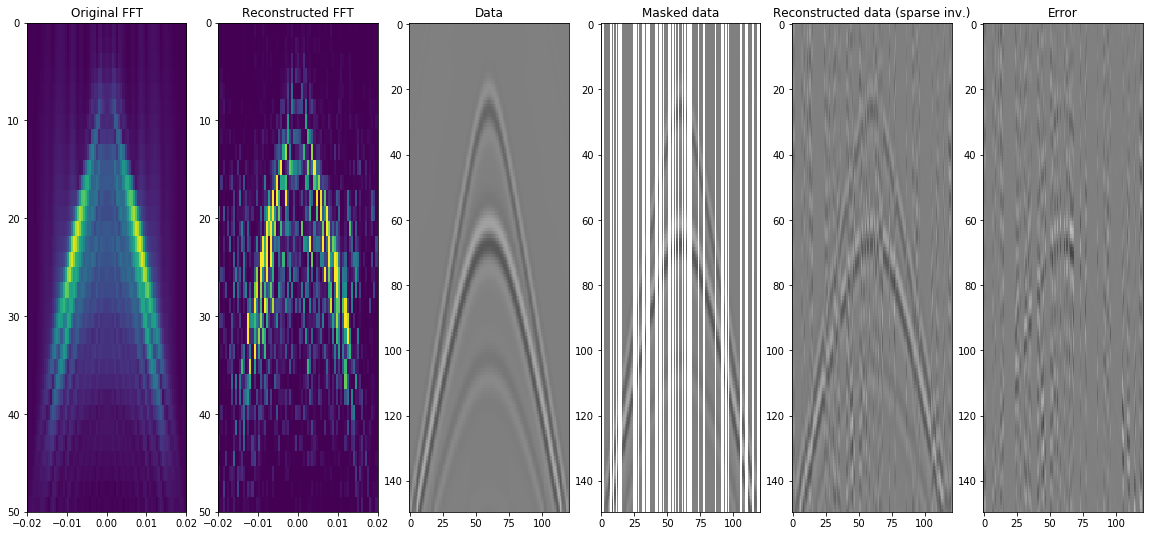

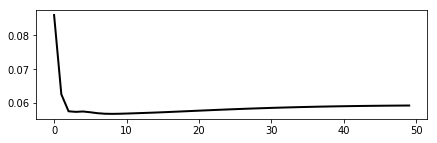

In [25]:
nfftk=2**7
nfft=2**8
FFTop = FFTND(dims=[par['ny'], par['nx'], par['nt']], nffts=[nfftk, nfftk, nfft], 
              sampling=[par['dy'], par['dx'], par['dt']])
dottest(FFTop, nfftk*nfftk*nfft, par['ny']*par['nx']*par['nt'], complexflag=2, verb=True)
p = FFTop*x.flatten()
p = np.reshape(p, (nfftk, nfftk, nfft))

pl1, niter, cost = FISTA(Rop*FFTop.H, y.flatten(), niter=50, eps=1e-4, returninfo=True)
xl1 = FFTop.H*pl1
pl1 = pl1.reshape(nfftk, nfftk, nfft)
xl1 = np.real(xl1.reshape(par['ny'], par['nx'], par['nt']))

fig, axs = plt.subplots(1, 6, figsize=(20, 9))
axs[0].imshow(np.fft.fftshift(np.abs(p[:, 1, :nfft//2-1]),axes=0).T, 
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=0.01)
axs[0].set_title('Original FFT')
axs[0].axis('tight')
axs[0].set_ylim(50, 0)
axs[0].set_xlim(-0.02, 0.02)
axs[1].imshow(np.fft.fftshift(np.abs(pl1[:, 1, :nfft//2-1]), axes=0).T,
              extent=(np.fft.fftshift(FFTop.fs[0])[0], np.fft.fftshift(FFTop.fs[0])[-1], 
                      FFTop.fs[2][nfft//2-1], FFTop.fs[2][0]), vmin=0, vmax=0.01)
axs[1].set_title('Reconstructed FFT')
axs[1].axis('tight')
axs[1].set_ylim(50, 0)
axs[1].set_xlim(-0.02, 0.02)
axs[2].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[2].set_title('Data')
axs[2].axis('tight');
axs[3].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[3].set_title('Masked data')
axs[3].axis('tight')
axs[4].imshow(xl1[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[4].set_title('Reconstructed data (sparse inv.)')
axs[4].axis('tight');
axs[5].imshow(x[:, par['nx']//2].T-xl1[:, par['nx']//2].T, cmap='gray', vmin=-0.01, vmax=0.01)
axs[5].set_title('Error')
axs[5].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);

### Inversion in parabolic Radon domain with sparsity-promoting solver

In [ ]:
npy=npx=41
pxmax = 4e-5
px = np.linspace(-pxmax/10, pxmax, npx)
Radop = Radon3D(taxis, yaxis, xaxis, px, px, centeredh=True, kind='parabolic', engine='numba')
#dottest(Radop, par['ny']*par['nx']*par['nt'], npy*npx*par['nt'], verb=True)

In [ ]:
Rop1 = Rop*Radop

# Radon on original data
xradadj = Radop.H*x.flatten()
xradadj = xradadj.reshape(npx, npx, par['nt'])

yradadj = Radop*xradadj.flatten()
yradadj = yradadj.reshape(par['ny'], par['nx'], par['nt'])

# Adjoint
xadj = Rop1.H*y.flatten()
xadj = xadj.reshape(npy, npx, par['nt'])

fig, axs = plt.subplots(1, 4, figsize=(20, 6))
axs[0].imshow(x[:, par['nx']//2].T, cmap='gray')
axs[0].set_title('Data')
axs[0].axis('tight')
axs[1].imshow(xradadj[:, npx//2].T, cmap='gray')
axs[1].set_title('Adjoint Radon on data')
axs[1].axis('tight')
axs[2].imshow(yradadj[:, par['nx']//2].T, cmap='gray')
axs[2].set_title('Modelled data from Adjoint Radon')
axs[2].axis('tight');
axs[3].imshow(xadj[:, npx//2].T, cmap='gray')
axs[3].set_title('Radon on Restricted data')
axs[3].axis('tight');

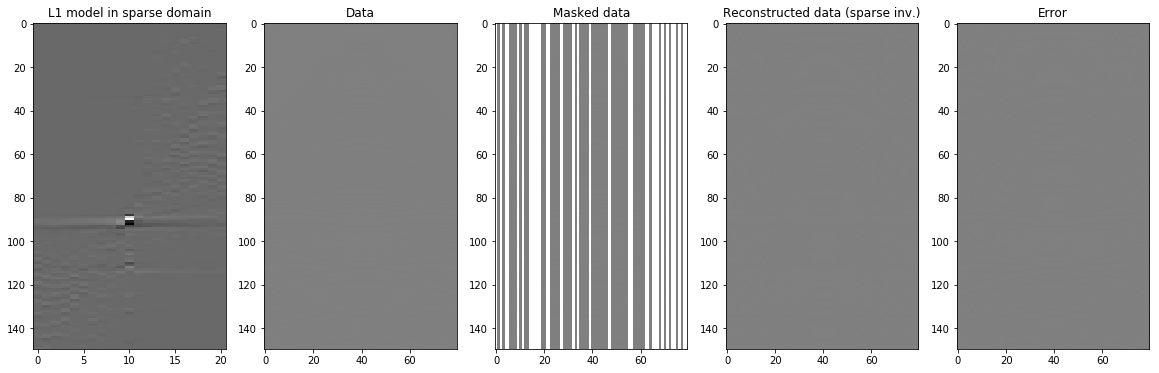

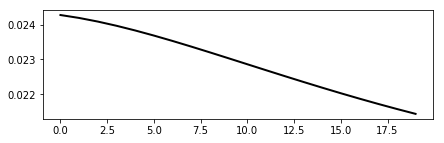

In [101]:
# Sparse inversion
pl1, niter, cost = FISTA(Rop1, y.flatten(), niter=20, eps=4e-2, returninfo=True)
xl1 = Radop*pl1

pl1 = pl1.reshape(npy, npx, par['nt'])
xl1 = np.real(xl1.reshape(par['ny'], par['nx'], par['nt']))

fig, axs = plt.subplots(1, 5, figsize=(20, 6))
axs[0].imshow(pl1[:, npx//2].T, cmap='gray')
axs[0].set_title('L1 model in sparse domain')
axs[0].axis('tight')
axs[1].imshow(x[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[1].set_title('Data')
axs[1].axis('tight');
axs[2].imshow(ymask[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[2].set_title('Masked data')
axs[2].axis('tight')
axs[3].imshow(xl1[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[3].set_title('Reconstructed data (sparse inv.)')
axs[3].axis('tight');
axs[4].imshow(x[:, par['nx']//2].T-xl1[:, par['nx']//2].T, cmap='gray', vmin=-2, vmax=2)
axs[4].set_title('Error')
axs[4].axis('tight');

plt.figure(figsize=(7, 2))
plt.plot(cost, 'k', lw=2);